# Column Descriptions

- Target
    - HeartDisease: Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI).
    
- Continuous
    - BMI: Body Mass Index (BMI).
    - PhysicalHealth: Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days).
    - MentalHealth: Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days).
    - AgeCategory: Fourteen-level age category. (then calculated the mean)
    - SleepTime: On average, how many hours of sleep do you get in a 24-hour period?
    
- Categorical:
    - Binary:
        - Stroke: (Ever told) (you had) a stroke?
        - DiffWalking: Do you have serious difficulty walking or climbing stairs?
        - Smoking: Have you smoked at least 100 cigarettes in your entire life?
        - AlcoholDrinking: Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week
        - Asthma: (Ever told) (you had) asthma?
        - KidneyDisease: Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?
        - SkinCancer: (Ever told) (you had) skin cancer?
        - PhysicalActivity: Adults who reported doing physical activity or exercise during the past 30 days other than their regular job.
    - Other: 
        - Diabetic: (Ever told) (you had) diabetes?
        - Sex: Are you male or female?
        - Race: Imputed race/ethnicity value.
    - Ordered Categorical
        - GenHealth: Would you say that in general your health is...excellent, very good, etc.

In [2]:
from typing import List

#general
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from dython import nominal
from dython.nominal import associations

sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(16,8)})

In [68]:
def mean_of_age_category(row):
    if "older" in row:
        return 80
    else:
        return np.mean(list(map(int, row.split("-"))))


def data_preprocessing(data: pd.DataFrame, categorical_features: List[str], continuous_features: List[str], target_variable: str):
    
    df = data.copy()
    
    # subset df
    #df = df[(df["Race"]=="White") | (df["Race"]=="Black")]
    df["AgeCategory"] = df["AgeCategory"].apply(mean_of_age_category)
    
    # target
    target = df[target_variable].values
    
    df_processed = df[categorical_features + continuous_features].copy() #.copy to avoid "SettingWithCopyWarning"

    # protected variables
    sex = df["Sex"].values
    age = df["AgeCategory"].values
    race = df["Race"].values
    
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_',
                                  dummy_na=False, columns=categorical_features, drop_first=True)

    return df_processed, df, target, race

In [69]:
train = pd.read_csv('data/heart_train.csv')
val = pd.read_csv('data/heart_val.csv')
test = pd.read_csv('data/heart_test.csv')

train1 = train.loc[train['Race'].isin(['White', 'Black'])]
val1 = val.loc[val['Race'].isin(['White', 'Black'])]
test1 = test.loc[test['Race'].isin(['White', 'Black'])]

target_variable = "HeartDisease"

categorical_features = [
    "Smoking",
    "AlcoholDrinking",
    "Stroke",
    "DiffWalking",
    "Sex",
    "AgeCategory",
    "Race",
    "Diabetic",
    "PhysicalActivity",
    "GenHealth",
    "Asthma",
    "KidneyDisease",
    "SkinCancer"
]

continuous_features = [
    "BMI",
    "PhysicalHealth",
    "MentalHealth"
]

train_processed, train_original, train_target, train_race = data_preprocessing(
    train1, categorical_features=categorical_features,
    continuous_features=continuous_features,
    target_variable=target_variable)

val_processed, val_original, val_target, val_race = data_preprocessing(
    val1, categorical_features=categorical_features,
    continuous_features=continuous_features,
    target_variable=target_variable)

test_processed, test_original, test_target, test_race = data_preprocessing(
    test1, categorical_features=categorical_features,
    continuous_features=continuous_features,
    target_variable=target_variable)

In [13]:
from IPython.display import display

def describe_df(df, col):
    for val in df[col].unique():
        print("Race: ", val)
        display(df[df[col]==val].describe()[['BMI','PhysicalHealth','MentalHealth', 'AgeCategory', 'SleepTime']].T.style.background_gradient(cmap='Blues'))

In [97]:
describe_df(train_processed, "Race_White")

Race:  1


,count,mean,std,min,25%,50%,75%,max
BMI,171703.000000,28.150102,6.194493,12.020000,23.910000,27.170000,31.200000,94.850000
PhysicalHealth,171703.000000,3.356453,7.945803,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,171703.000000,3.811582,7.835912,0.000000,0.000000,0.000000,3.000000,30.000000
AgeCategory,171703.000000,56.251195,17.349985,21.000000,42.000000,57.000000,72.000000,80.000000
SleepTime,171703.000000,7.132951,1.368425,1.000000,6.000000,7.000000,8.000000,24.000000


Race:  0


,count,mean,std,min,25%,50%,75%,max
BMI,16100.000000,30.179532,7.190015,12.020000,25.100000,29.050000,33.840000,92.530000
PhysicalHealth,16100.000000,3.733851,8.176771,0.000000,0.000000,0.000000,2.000000,30.000000
MentalHealth,16100.000000,4.233975,8.396428,0.000000,0.000000,0.000000,4.000000,30.000000
AgeCategory,16100.000000,52.198944,17.001393,21.000000,37.000000,52.000000,67.000000,80.000000
SleepTime,16100.000000,7.003975,1.856217,1.000000,6.000000,7.000000,8.000000,24.000000


In [318]:
pd.DataFrame(train_processed.groupby("Race_White").mean())

,BMI,PhysicalHealth,MentalHealth,SleepTime,AgeCategory,PhysicalActivity_Yes,SkinCancer_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,...,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),Asthma_Yes,Stroke_Yes,DiffWalking_Yes,AlcoholDrinking_Yes,Sex_Male,Smoking_Yes,KidneyDisease_Yes
Race_White,,,,,,,,,,,,,,,,,,,,,
0,30.179532,3.733851,4.233975,7.003975,52.198944,0.711366,0.005714,0.160994,0.353727,0.042609,...,0.028199,0.197578,0.008137,0.160870,0.055217,0.187702,0.045652,0.407453,0.345342,0.043851
1,28.150102,3.356453,3.811582,7.132951,56.251195,0.790097,0.116078,0.098356,0.278842,0.034711,...,0.018066,0.119986,0.007035,0.128891,0.037378,0.135793,0.072183,0.479823,0.431792,0.037652


# Binary Feature Counts

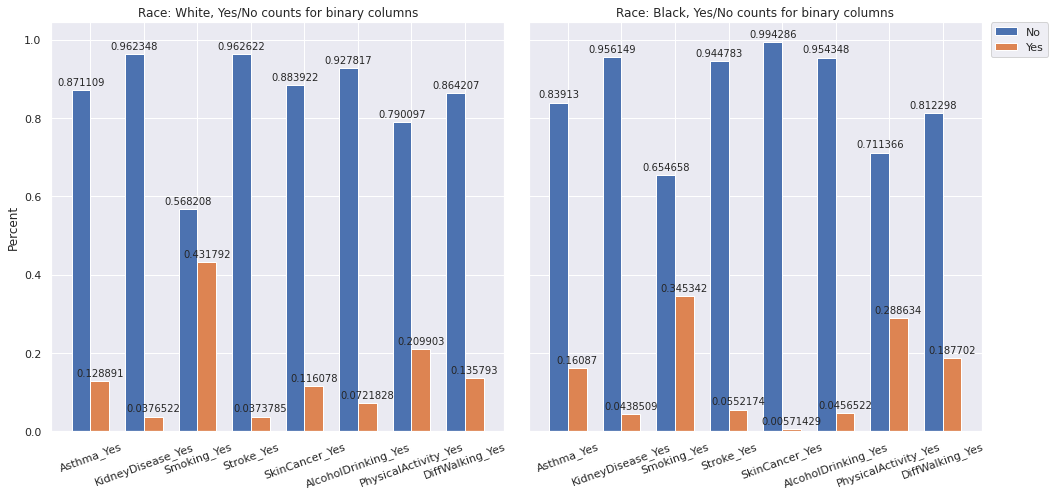

In [319]:
binary_features = ["Asthma_Yes", "KidneyDisease_Yes", "Smoking_Yes", "Stroke_Yes", 
                   "SkinCancer_Yes", "AlcoholDrinking_Yes", "PhysicalActivity_Yes", "DiffWalking_Yes"]

fig, ax = plt.subplots(1, 2, figsize=(14,7), sharey=True)
x = np.arange(len(binary_features))
width = 0.35

for val in train_processed["Race_White"].unique():
    no = []
    yes = []
    
    for col in binary_features:
        n, y = train_processed[train_processed["Race_White"]==val][col].value_counts(normalize=True).values
        no.append(n)
        yes.append(y)
    
    if val == 1:
        rects1 = ax[0].bar(x - width/2, no, width, label='No')
        rects2 = ax[0].bar(x + width/2, yes, width, label='Yes')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[0].set_ylabel('Percent')
        ax[0].set_title('Race: White, Yes/No counts for binary columns')
        ax[0].set_xticks(x, binary_features, rotation=20)
        
        ax[0].bar_label(rects1, padding=3)
        ax[0].bar_label(rects2, padding=3)
    else:
        rects1 = ax[1].bar(x - width/2, no, width, label='No')
        rects2 = ax[1].bar(x + width/2, yes, width, label='Yes')
        
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax[1].set_title('Race: Black, Yes/No counts for binary columns')
        ax[1].set_xticks(x, binary_features, rotation=20)
        
        ax[1].bar_label(rects1, padding=3)
        ax[1].bar_label(rects2, padding=3)

#ax.legend()

fig.tight_layout()
plt.legend(loc=2, labels=['No', 'Yes'], bbox_to_anchor=(1.02, 1), borderaxespad=0.)
plt.show()

# Continuous Counts

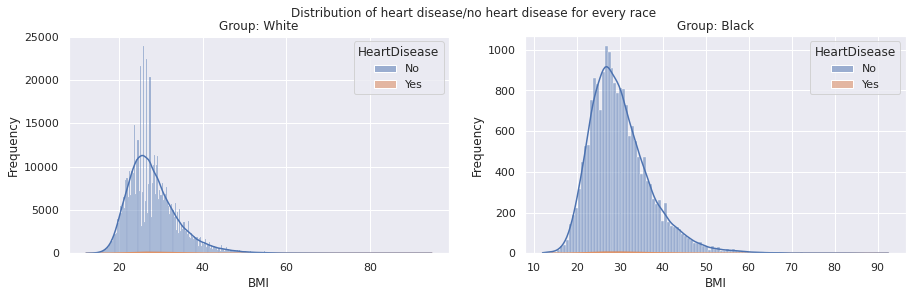

In [168]:
def histplot(df, target, groups, x_feature, colors=["#ea4335", '#4285f4']):
    # creating a figure composed of n_hist matplotlib.Axes objects
    f, ax_hist = plt.subplots(1, 2, figsize=(15,4))
    
    f.suptitle('Distribution of heart disease/no heart disease for every race')
    
    for i, group in enumerate(df[groups].unique()):
        sns.histplot(df[df[groups]==group], x=x_feature, hue=target, 
                         kde=True, stat="frequency", ax=ax_hist[i])
        ax_hist[i].set_title(f"Group: {group}")
    plt.show()

histplot(train_original, "HeartDisease", "Race", "BMI")    
    

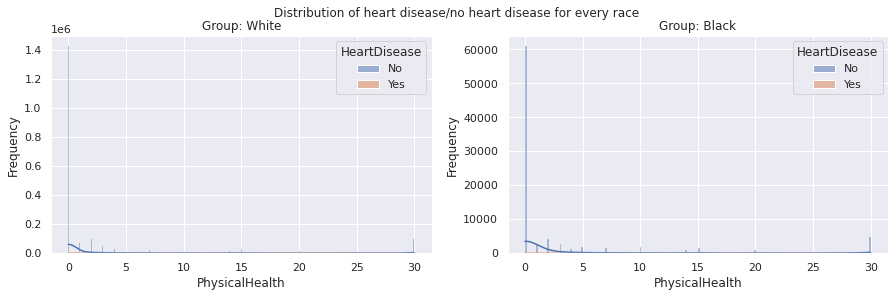

In [169]:
histplot(train_original, "HeartDisease", "Race", "PhysicalHealth")

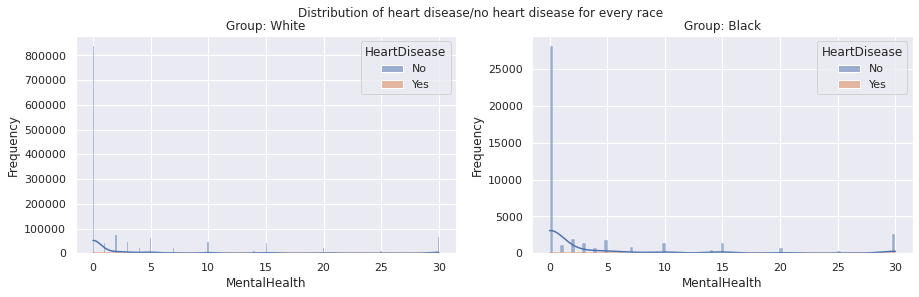

In [170]:
histplot(train_original, "HeartDisease", "Race", "MentalHealth")

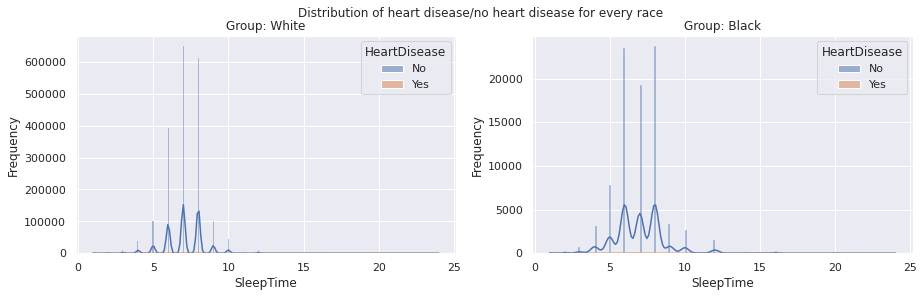

In [171]:
histplot(train_original, "HeartDisease", "Race", "SleepTime")

# Distribution of heartdisease, kidneydisease, skincancer across age category per race

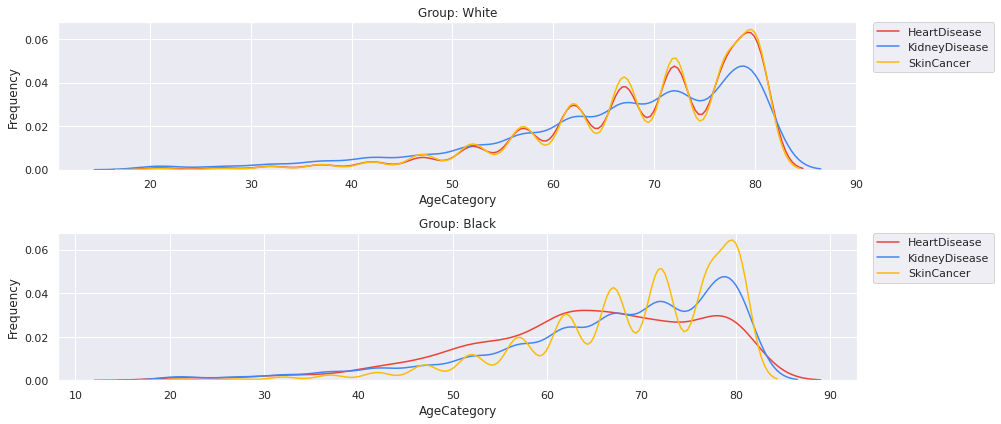

In [262]:
fig, ax = plt.subplots(2, 1, figsize = (14,6))

for i, group in enumerate(train_original["Race"].unique()):
    sns.kdeplot(train_original[(train_original["HeartDisease"]=="Yes") & (train_original["Race"]==group)]["AgeCategory"], alpha=1,shade = False, color="#ea4335", label="HeartDisease", ax = ax[i])
    sns.kdeplot(train_original[train_original["KidneyDisease"]=="Yes"]["AgeCategory"], alpha=1,shade = False, color="#4285f4", label="KidneyDisease", ax = ax[i])
    sns.kdeplot(train_original[train_original["SkinCancer"]=="Yes"]["AgeCategory"], alpha=1,shade = False, color="#fbbc05", label="SkinCancer", ax = ax[i])
    ax[i].set_title(f"Group: {group}")
    ax[i].set_xlabel("AgeCategory")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

In [188]:
print("White: ")
print(train_original[train_original["Race"]=="White"]["HeartDisease"].value_counts(normalize=True), "\n")
print("Black: ")
print(train_original[train_original["Race"]=="Black"]["HeartDisease"].value_counts(normalize=True))

White: 
No     0.908266
Yes    0.091734
Name: HeartDisease, dtype: float64 

Black: 
No     0.923416
Yes    0.076584
Name: HeartDisease, dtype: float64


----

# Diabetes for Categoricals across sex and race

In [20]:
target = "HeartDisease"
group = "Race"
subgroup = "Sex"
indexes = "AgeCategory"
categoricals = list(set(categorical_features) - set([group, subgroup]))
continuous = list(set(continuous_features) - set(["AgeCategory"]))

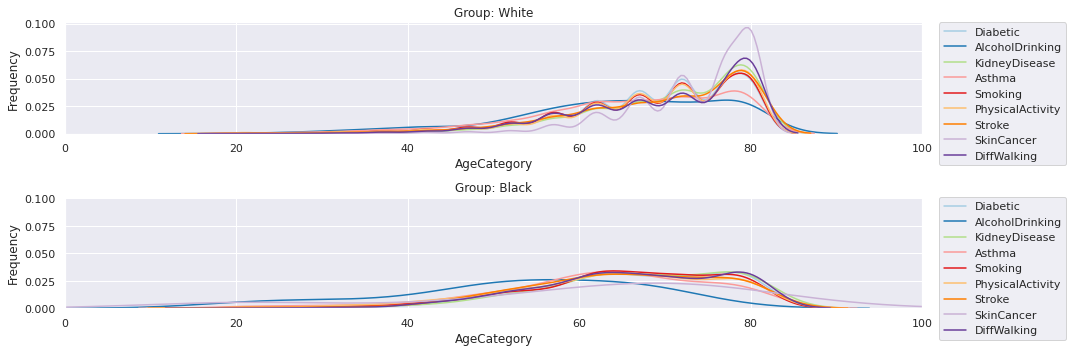

In [132]:
fig, axes = plt.subplots(2, 1, figsize= (15, 5), sharey=True)
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"]


for i, g in enumerate(train_original[group].unique()):
    for c, cat in enumerate(categoricals):
        sns.kdeplot(train_original[(train_original[target]=="Yes") 
                               & (train_original[cat]=="Yes")
                               & (train_original[group]==g)][indexes], alpha=1, shade=False, color=colors[c],
               label=cat, ax=axes[i])
    axes[i].set_title(f"Group: {g}")
    axes[i].set_xlabel("AgeCategory")
    axes[i].set_ylabel("Frequency")
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    axes[i].set_xlim(0, 100)
plt.tight_layout()
plt.savefig("diseases_frequency_white_black.png", dpi=400)

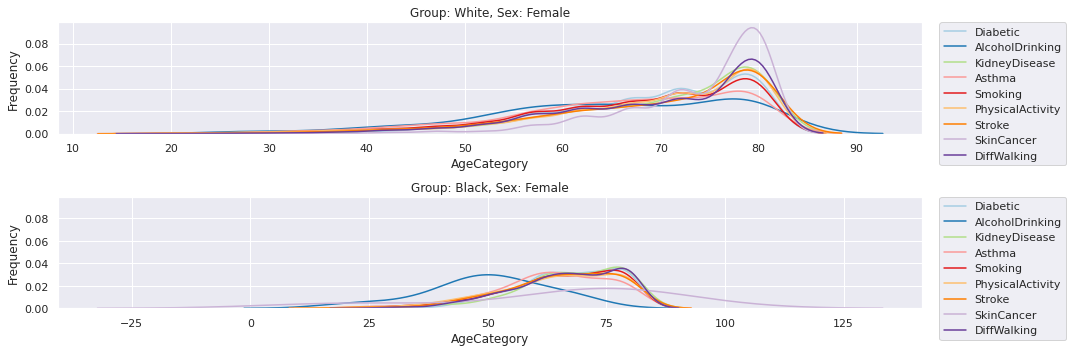

In [75]:
fig, axes = plt.subplots(2, 1, figsize= (15, 5), sharey=True)
colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"]

gender = "Female"

for i, g in enumerate(train_original[group].unique()):
    for c, cat in enumerate(categoricals):
        sns.kdeplot(train_original[(train_original[target]=="Yes") 
                               & (train_original[cat]=="Yes")
                               & (train_original[group]==g) 
                               & (train_original["Sex"]==gender)][indexes], alpha=1, shade=False, color=colors[c],
               label=cat, ax=axes[i])
    axes[i].set_title(f"Group: {g}, Sex: {gender}")
    axes[i].set_xlabel("AgeCategory")
    axes[i].set_ylabel("Frequency")
    axes[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig("diseases_frequency_male_white_black.png", dpi=400)

In [291]:
disease_cols = ["Race_White", "PhysicalActivity_Yes", "SkinCancer_Yes", "Diabetic_Yes", "Asthma_Yes", "Stroke_Yes", "DiffWalking_Yes", "AlcoholDrinking_Yes", "Smoking_Yes", "KidneyDisease_Yes"]

df1 = train_processed[disease_cols]

In [297]:
df1.groupby("Race_White").mean()

,PhysicalActivity_Yes,SkinCancer_Yes,Diabetic_Yes,Asthma_Yes,Stroke_Yes,DiffWalking_Yes,AlcoholDrinking_Yes,Smoking_Yes,KidneyDisease_Yes
Race_White,,,,,,,,,
0,0.711366,0.005714,0.197578,0.160870,0.055217,0.187702,0.045652,0.345342,0.043851
1,0.790097,0.116078,0.119986,0.128891,0.037378,0.135793,0.072183,0.431792,0.037652


In [316]:
df1[df1["Race_White"]==1].loc[:, df1.columns!="Race_White"].sum(axis=1).mean()

1.869850847102264

In [317]:
df1[df1["Race_White"]==0].loc[:, df1.columns!="Race_White"].sum(axis=1).mean()

1.7532919254658386

# Correlations

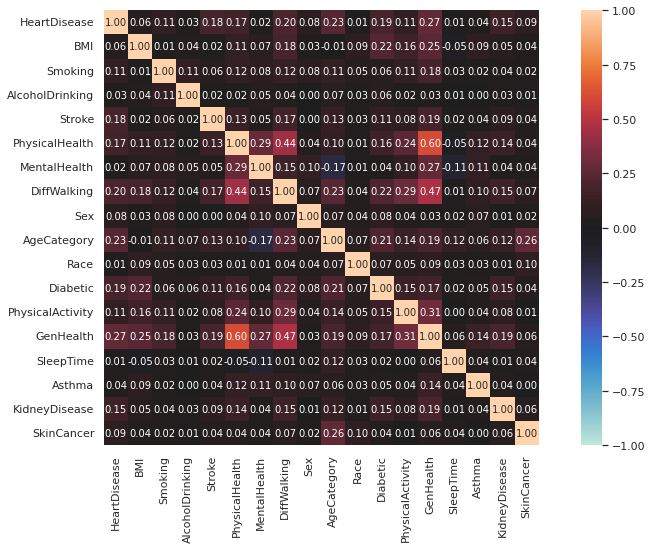

In [261]:
associations(train_original, figsize=(15, 8))
plt.show()

# Quick Stats

In [47]:
train_total_black = sum(train_original["Race"]=="Black")
train_total_white = len(train_original) - train_total_black

val_total_black = sum(val_original["Race"]=="Black")
val_total_white = len(val_original) - val_total_black

test_total_black = sum(test_original["Race"]=="Black")
test_total_white = len(test_original) - test_total_black

total_black = train_total_black + val_total_black + test_total_black
total_white = train_total_white + val_total_white + test_total_white

print("Total black: ", total_black)
print("Total white: ", total_white)
print("Total: ", total_black+total_white)

Total black:  22939
Total white:  245212
Total:  268151


In [52]:
print("Black percent in train, val and test: ", train_total_black / len(train_original), val_total_black / len(val_original), test_total_black / len(test_original))

Black percent in train, val and test:  0.08572813000857281 0.08478125389505173 0.08545224069793453


In [53]:
print("White percent in train, val and test: ", train_total_white / len(train_original), val_total_white / len(val_original), test_total_white / len(test_original))

White percent in train, val and test:  0.9142718699914272 0.9152187461049482 0.9145477593020654


In [122]:
sum(val_original[train_original["Race"]=="Black"]["HeartDisease"] == "Yes")

KeyboardInterrupt: 

In [126]:
sum(val_original[val_original["Race"]=="White"]["HeartDisease"] == "Yes") / len(val_original)

0.08341019568739873

In [31]:
np.mean(pd.factorize(train_original[train_original["Race"]=="White"]["GenHealth"])[0])

1.8066719859291918

In [32]:
np.mean(pd.factorize(train_original[train_original["Race"]=="Black"]["GenHealth"])[0])

1.2566459627329192

In [34]:
sum(train_original["Race"]=="Black"), sum(val_original["Race"]=="Black"), sum(test_original["Race"]=="Black")

NameError: name 'val_original' is not defined

In [ ]:
# train test split table, # n rows, white black proportion, 

# short descriptive table, 

In [56]:
len(test_original)

40233